<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-5/5_01_memory_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Memory
## Review
Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

There are [various long-term memory types](https://langchain-ai.github.io/langgraph/concepts/memory/) that can be used in AI applications.

## Goals

Here, we'll introduce the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We'll build a chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

We'll focus on long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory), which will be facts about the user.

These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

It will save memory ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

In [77]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core

We'll use [LangSmith ](https://https://docs.smith.langchain.com/)for [tracing](https://docs.smith.langchain.com/observability/concepts).

In [78]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Introduction to the LangGraph Store
The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information *across threads* in LangGraph.

This is an [open source base class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value `stores.

In [79]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the Store, we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)
We use the put method to save an object to the store by `namespace` and key.

In [80]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

In [81]:
type(namespace_for_memory)

tuple

In [82]:
key

'8335f2f0-e6b3-4985-a969-1b3fd0de39ea'

In [83]:
# The value needs to be a dictionary
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

We use search to retrieve objects from the store by `namespace`.

This returns a list.

In [84]:
# Search
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [85]:
memories

[Item(namespace=['1', 'memories'], key='8335f2f0-e6b3-4985-a969-1b3fd0de39ea', value={'food_preference': 'I like pizza'}, created_at='2025-01-11T11:21:22.818212+00:00', updated_at='2025-01-11T11:21:22.818220+00:00', score=None)]

In [86]:
# Metatdata
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '8335f2f0-e6b3-4985-a969-1b3fd0de39ea',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-01-11T11:21:22.818212+00:00',
 'updated_at': '2025-01-11T11:21:22.818220+00:00',
 'score': None}

In [87]:
# The key, value
print(memories[0].key, memories[0].value)

8335f2f0-e6b3-4985-a969-1b3fd0de39ea {'food_preference': 'I like pizza'}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

In [88]:
key

'8335f2f0-e6b3-4985-a969-1b3fd0de39ea'

In [89]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '8335f2f0-e6b3-4985-a969-1b3fd0de39ea',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-01-11T11:21:22.818212+00:00',
 'updated_at': '2025-01-11T11:21:22.818220+00:00'}

## Chatbot with long-term memory
We want a chatbot that has two types of memory:

1. `Short-term (within-thread) memory:` Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory:` Chatbot can remember information about a specific user across all chat sessions.

In [90]:
# os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')

For `short-term memory`, we'll use a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).

See Module 2 and our [conceptual docs](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) for more on checkpointers, but in summary:

They write the graph state at each step to a thread.
They persist the chat history in the thread.
They allow the graph to be interrupted and / or resumed from any step in the thread.
And, for `long-term memory`, we'll use the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as introduced above.

In [91]:
# %pip install -qU langchain-google-genai

In [92]:
%pip install -qU langchain langchain-groq

In [93]:
# from langchain_google_genai import ChatGoogleGenerativeAI

# model = ChatGoogleGenerativeAI(
#     model="gemini-1.5-flash",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
#     # other params...
# )

In [94]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [95]:
from langchain_groq import ChatGroq  # Assuming langchain-groq is available

# Initialize the Groq client with the Llama 3.3-70b model
model= ChatGroq(
    model="llama-3.3-70b-versatile",  # Specify the model name
    temperature=0,                    # Control randomness (0 for deterministic output)
    max_tokens=100,                   # Maximum number of tokens to generate
    timeout=30,                       # Timeout for the request
    max_retries=2,                    # Number of retries in case of failure
)


In [96]:
model.invoke("hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.083636364, 'prompt_time': 0.007166644, 'queue_time': 0.017093165, 'total_time': 0.090803008}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'stop', 'logprobs': None}, id='run-dfbafc85-edd0-4261-b106-50f278e4317e-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

The chat history will be saved to short-term memory using the checkpointer.

The chatbot will reflect on the chat history.

It will then create and save a memory to the [LangGraph Store.](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get)

This memory is accessible in future chat sessions to personalize the chatbot's responses.

In [97]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [98]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about
the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

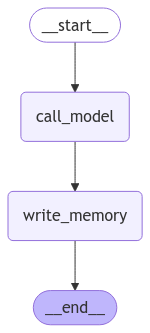

In [99]:

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice.

In [100]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Rizwan")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Rizwan
================================== Ai Message ==================================

Hello Rizwan, it's nice to meet you. I'll make a note of your name so I can address you personally in our conversation. Is there something I can help you with or would you like to chat?


In [101]:
# User input
input_messages = [HumanMessage(content="I like to bike around Stuttgart")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around Stuttgart
================================== Ai Message ==================================

Stuttgart is a beautiful city with a lot to offer. Biking is a great way to explore it. The city has many bike paths and trails, including the popular Neckar River cycle path. Have you tried biking up to the Killesberg park or the Stuttgart vineyards? They offer some great views of the city. What do you like most about biking in Stuttgart, Rizwan?


We're using the `MemorySaver` checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [102]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Rizwan
================================== Ai Message ==================================

Hello Rizwan, it's nice to meet you. I'll make a note of your name so I can address you personally in our conversation. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

I like to bike around Stuttgart
================================== Ai Message ==================================

Stuttgart is a beautiful city with a lot to offer. Biking is a great way to explore it. The city has many bike paths and trails, including the popular Neckar River cycle path. Have you tried biking up to the Killesberg park or the Stuttgart vineyards? They offer some great views of the city. What do you like most about biking in Stuttgart, Rizwan?


Recall that we compiled the graph with our the store:

across_thread_memory = InMemoryStore()

And, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.

We can to see if the memory was saved to the store.

In [103]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': " \n\nAlso, I'll update your user information:\n\n* Name: Rizwan\n* Location: Stuttgart\n* Interests: Biking \n\nLet me know if you'd like to share more about yourself!"},
 'created_at': '2025-01-11T11:22:43.594764+00:00',
 'updated_at': '2025-01-11T11:22:43.594767+00:00'}

Now, let's kick off a *new thread* with the *same user ID*.

We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [104]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "245433444", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi! What do you know about me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! What do you know about me?
================================== Ai Message ==================================

Hello Rizwan! I'm glad you asked. I have some basic information about you. I know that you're from Stuttgart, and one of your interests is biking. Is there anything else you'd like to share about yourself or would you like some recommendations on biking routes in Stuttgart?


In [105]:
# User input
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

A croissant after biking sounds like a great way to refuel, Rizwan. Stuttgart has a lot of wonderful bakeries. There's a popular one called Bäckerei Zimmermann near the city center, and another one called Konditorei Café Walter that's known for its delicious pastries. Both of these bakeries are within a reasonable distance from some of the popular biking trails in Stuttgart. Would you like more specific directions or recommendations on which trails to take to get to


## Assignment
1. Add Long Term Memoery to 01 using interrupt and long term memory.
## Viewing traces in LangSmith
We can see that the memories are retrieved from the store and supplied as part of the system prompt, as expected:

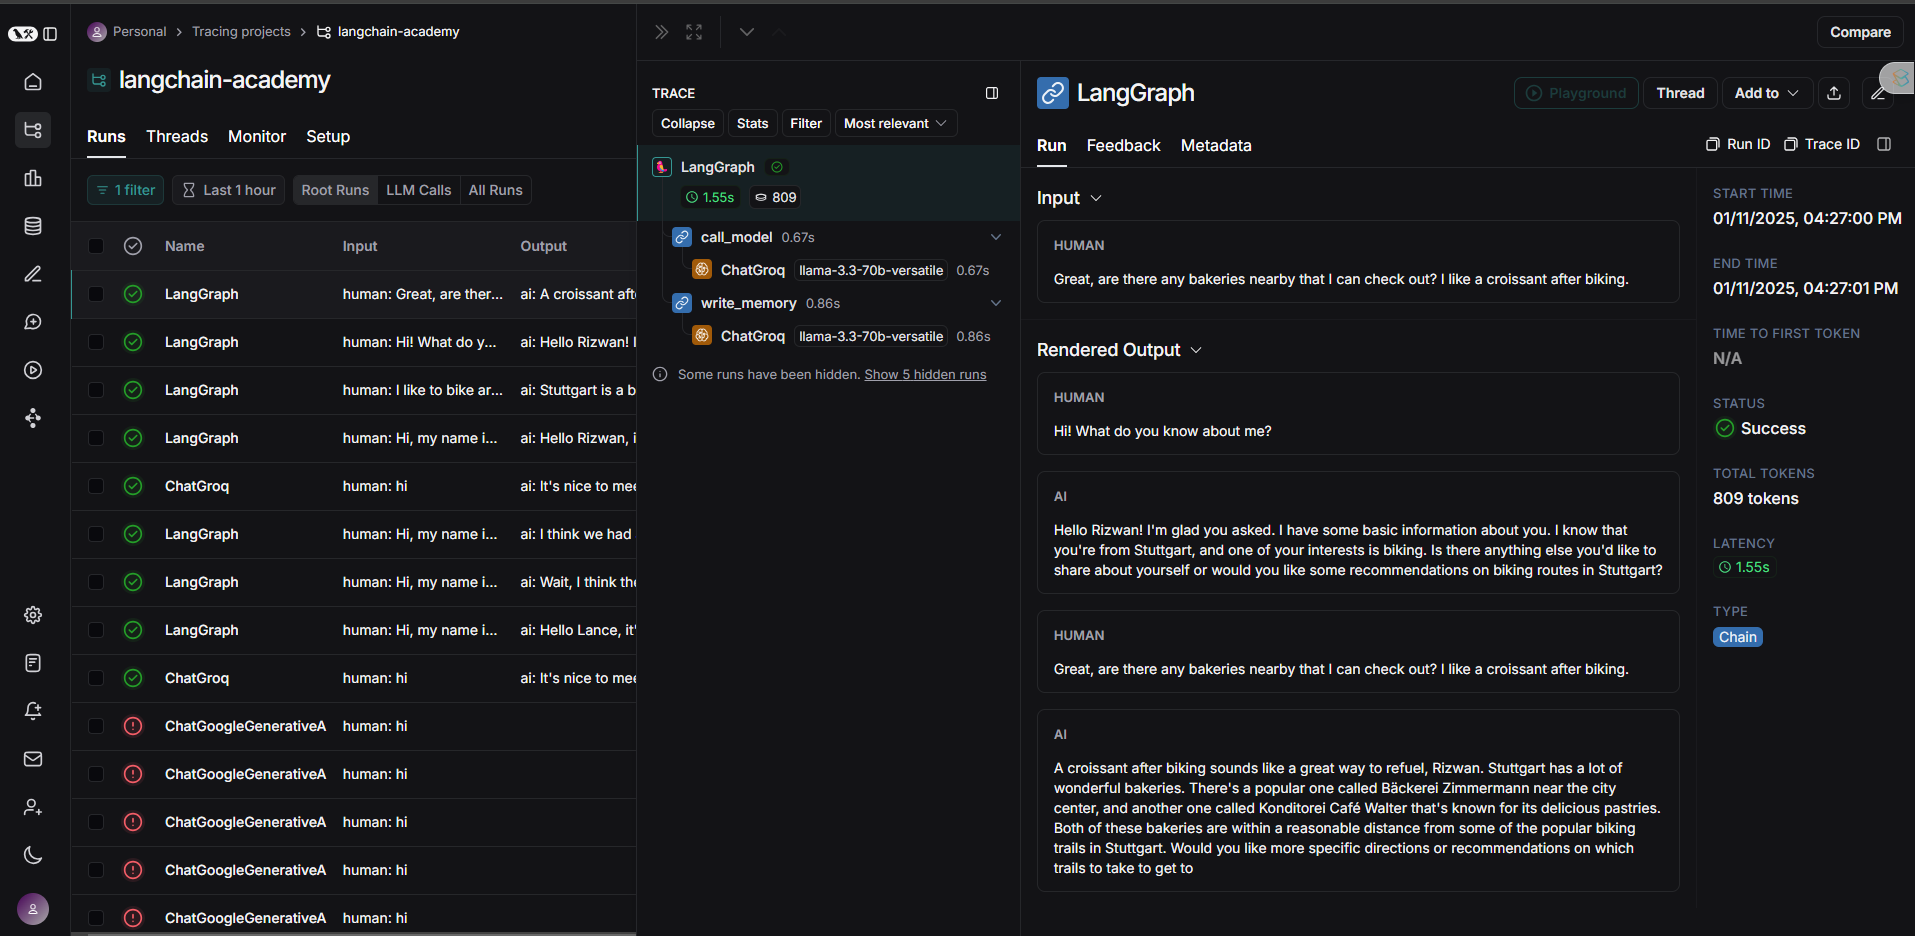

https://smith.langchain.com/public/d82beb6e-449a-4b5d-ac23-d6755ded5675/r